In [1]:
!pip install blitz-bayesian-pytorch


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

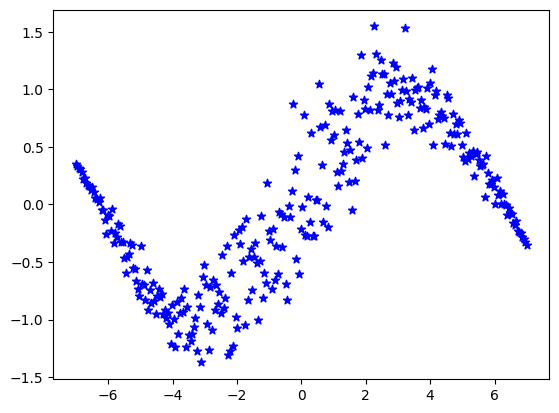

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

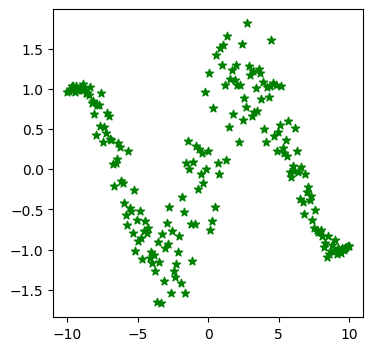

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

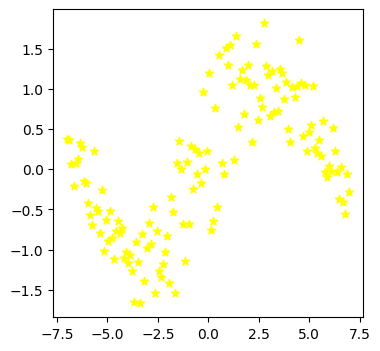

In [7]:
#Plotting In Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask =  (x_test >= -7) &  (x_test <= 7) # Select the ranges -10 to -7 and 7 to 10
x_test_idd = x_test[mask]
y_test_idd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_idd, y_test_idd, c="yellow", marker="*")

plt.show()


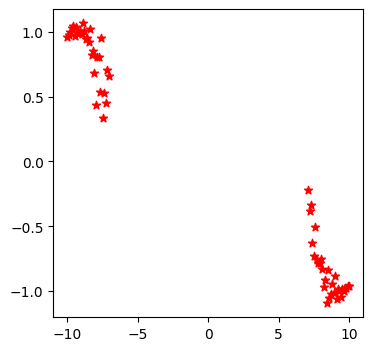

In [8]:
#Plotting Out of Training Distribution Data Points in the Test Set
# Filter the data to retain only the desired ranges
mask = (x_test >= -10) & (x_test < -7) | (x_test > 7) & (x_test <= 10) # Select the ranges -10 to -7 and 7 to 10
x_test_oodd = x_test[mask]
y_test_oodd = y_test[mask]

plt.figure(figsize=(4, 4))
plt.scatter(x_test_oodd, y_test_oodd, c="red", marker="*")

plt.show()


In [9]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Test for OODD (Out of Data Distribution)
tensor_x_test_oodd = torch.Tensor(x_test_oodd).unsqueeze(1)
tensor_y_test_oodd = torch.Tensor(y_test_oodd).unsqueeze(1)
test_dataset_oodd = TensorDataset(tensor_x_test_oodd, tensor_y_test_oodd)
test_loader_oodd = DataLoader(test_dataset_oodd, batch_size=batch_size, shuffle=True)

#Test for IDD (In Data Distribution)
tensor_x_test_idd = torch.Tensor(x_test_idd).unsqueeze(1)
tensor_y_test_idd = torch.Tensor(y_test_idd).unsqueeze(1)
test_dataset_idd = TensorDataset(tensor_x_test_idd, tensor_y_test_idd)
test_loader_idd = DataLoader(test_dataset_idd, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [10]:
class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 61

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out



In [11]:
model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (fc1): Linear(in_features=1, out_features=61, bias=True)
  (fc2): Linear(in_features=61, out_features=61, bias=True)
  (out): Linear(in_features=61, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 3966


In [12]:
sns.set(rc={'figure.figsize':(4, 4)})
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]
    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)
    df = pd.concat(dfs).reset_index()
    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)
    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)
    plt.savefig("mcdo.png", dpi=300, bbox_inches='tight')  # Add this line
    plt.show()

In [13]:
def make_plot_mcdo_oodd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_oodd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_oodd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_oodd, y_test_oodd, c="red", marker="*", alpha=0.1)
    plt.show()

In [14]:
def make_plot_mcdo_idd(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test_idd) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test_idd.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test_idd, y_test_idd, c="yellow", marker="*", alpha=0.1)
    plt.show()

In [15]:
def MLE_mcdo():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [16]:
def MLE_mcdo_oodd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_oodd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_oodd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


In [17]:
def MLE_mcdo_idd():
  criterion = torch.nn.MSELoss()
  model = MCDO()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model.to(device)

  for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader_idd:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)

  make_plot_mcdo_idd(model)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


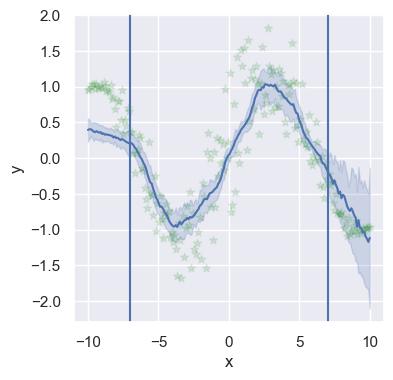

Epoch 149 | batch train loss: 0.10372406989336014 | test loss: 0.19559997205550855


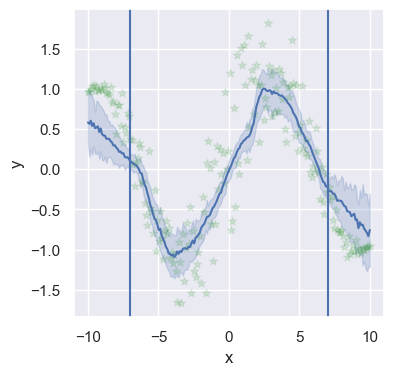

Epoch 149 | batch train loss: 0.04361175373196602 | test loss: 0.19460920129831022


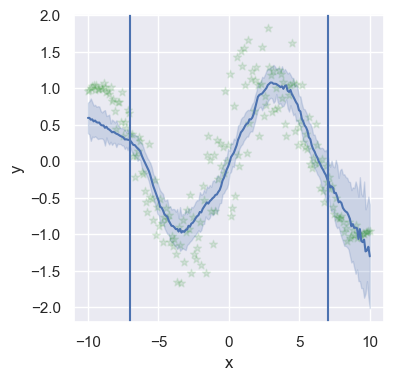

Epoch 149 | batch train loss: 0.05692529305815697 | test loss: 0.1978280280645077


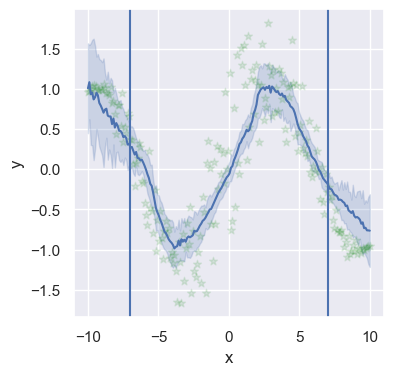

Epoch 149 | batch train loss: 0.08146441727876663 | test loss: 0.19268865768726057


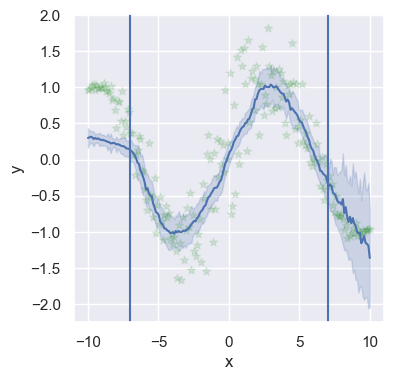

Epoch 149 | batch train loss: 0.0974816083908081 | test loss: 0.2276672239486988


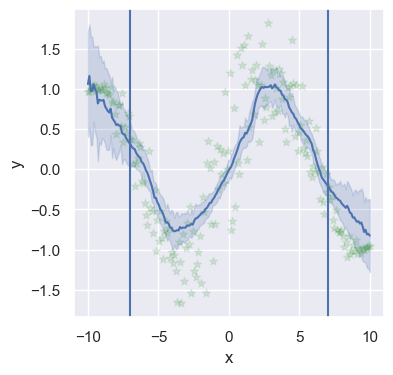

Epoch 149 | batch train loss: 0.06823510676622391 | test loss: 0.1825955561720408


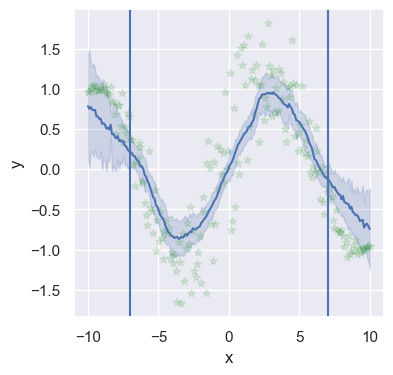

Epoch 149 | batch train loss: 0.035949043929576874 | test loss: 0.16845205196967492


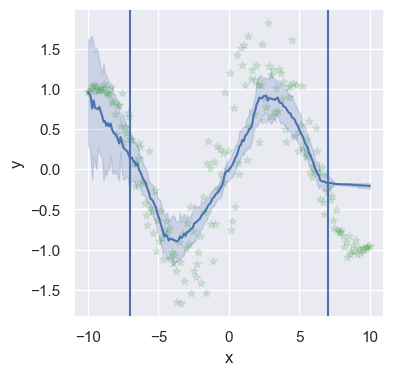

Epoch 149 | batch train loss: 0.0577760748565197 | test loss: 0.22581324439782363


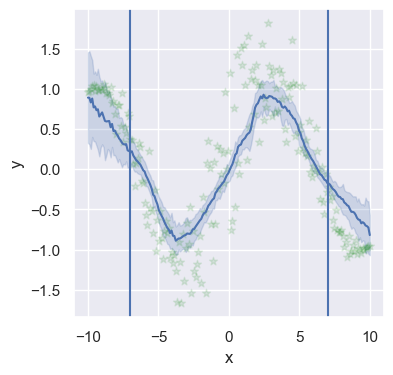

Epoch 149 | batch train loss: 0.039967991411685944 | test loss: 0.20624667062209204


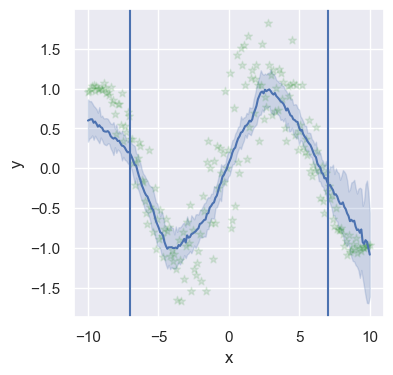

Epoch 149 | batch train loss: 0.11539915949106216 | test loss: 0.18645353615283966


In [18]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


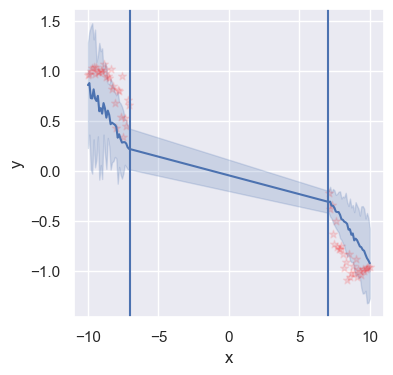

Epoch 149 | batch train loss: 0.04886605963110924 | test loss: 0.1401972658932209


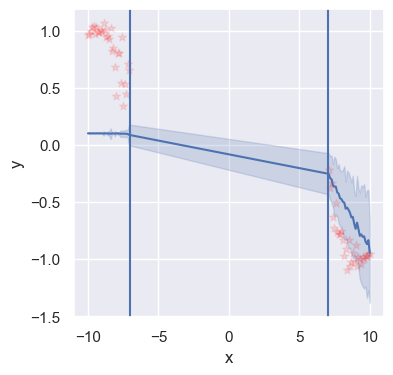

Epoch 149 | batch train loss: 0.09458788484334946 | test loss: 0.33000998571515083


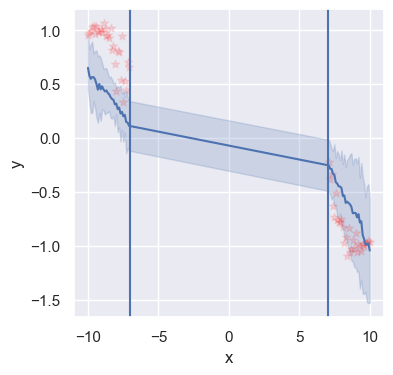

Epoch 149 | batch train loss: 0.024766534566879272 | test loss: 0.2048422247171402


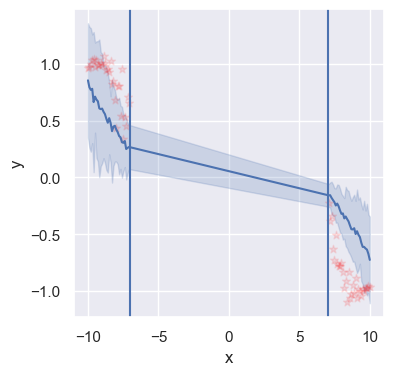

Epoch 149 | batch train loss: 0.07506115734577179 | test loss: 0.10062665864825249


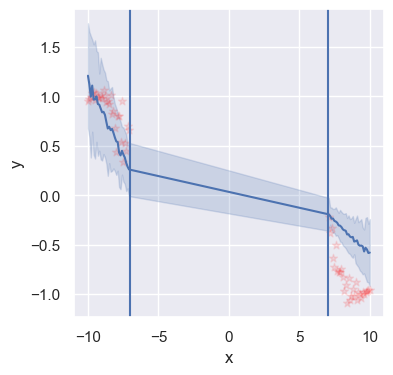

Epoch 149 | batch train loss: 0.16824857890605927 | test loss: 0.11924403719604015


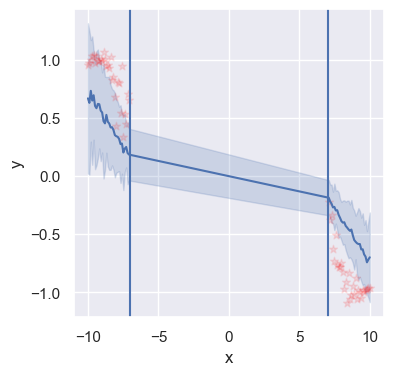

Epoch 149 | batch train loss: 0.08980267494916916 | test loss: 0.1530061438679695


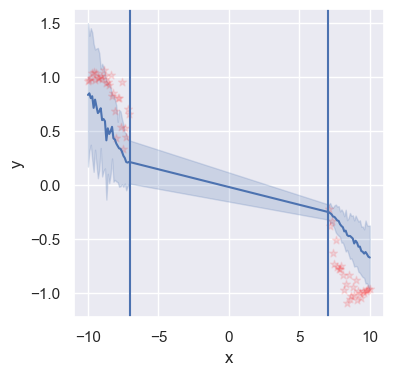

Epoch 149 | batch train loss: 0.055847376585006714 | test loss: 0.11320407129824162


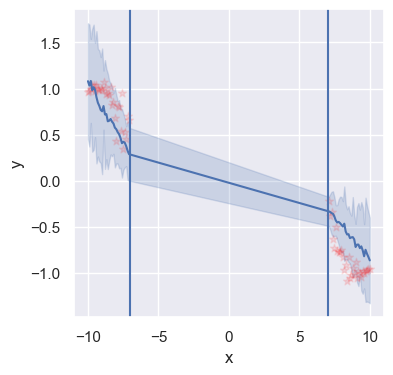

Epoch 149 | batch train loss: 0.10623785853385925 | test loss: 0.13973290286958218


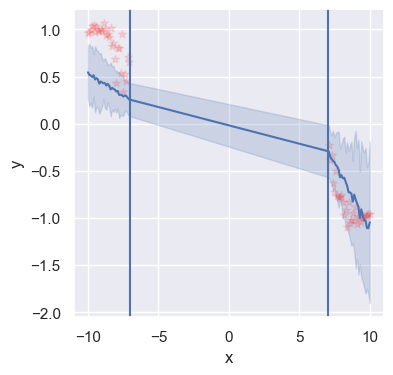

Epoch 149 | batch train loss: 0.09670376777648926 | test loss: 0.16788342595100403


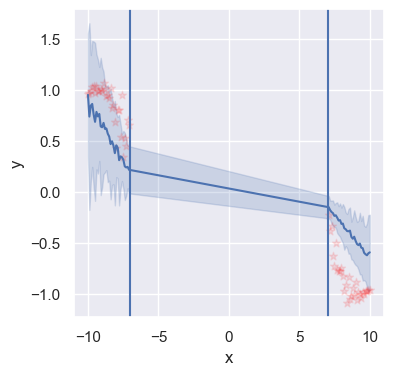

Epoch 149 | batch train loss: 0.1263572722673416 | test loss: 0.13892276026308537


In [19]:
train_losses_oodd=[]
test_losses_oodd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_oodd()
  train_losses_oodd.append(tr_loss)
  test_losses_oodd.append(test_loss)


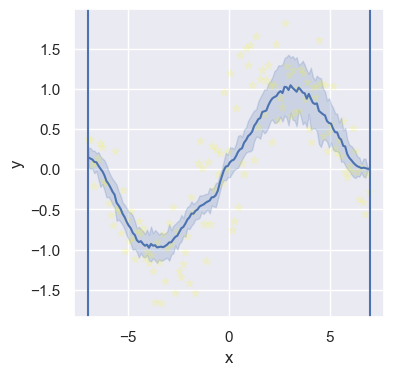

Epoch 149 | batch train loss: 0.09967821091413498 | test loss: 0.20815414355860817


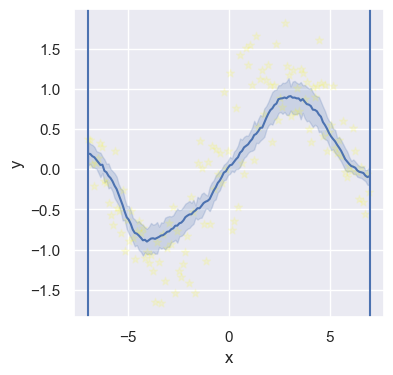

Epoch 149 | batch train loss: 0.07271437346935272 | test loss: 0.210451849632793


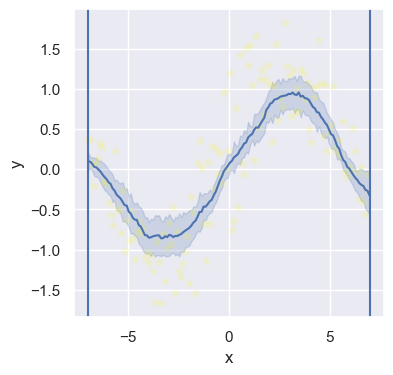

Epoch 149 | batch train loss: 0.13199205696582794 | test loss: 0.21208047535684374


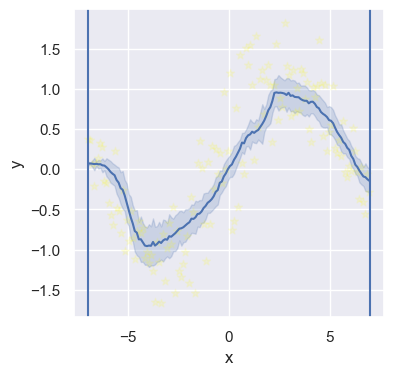

Epoch 149 | batch train loss: 0.05254245921969414 | test loss: 0.1945311940378613


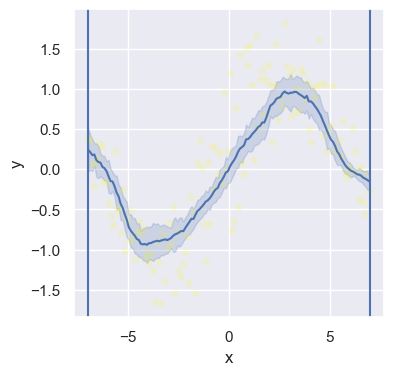

Epoch 149 | batch train loss: 0.05285249277949333 | test loss: 0.20446040978034338


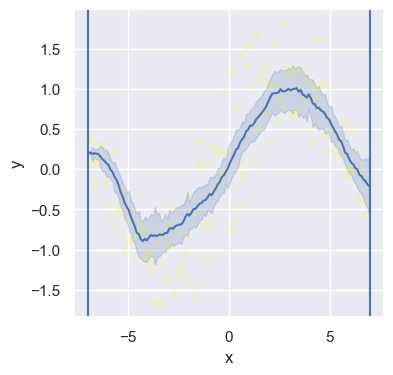

Epoch 149 | batch train loss: 0.06041872501373291 | test loss: 0.19969582888815138


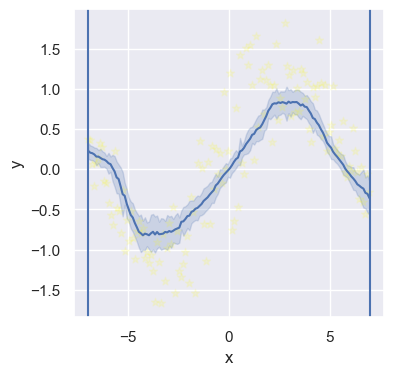

Epoch 149 | batch train loss: 0.0382157601416111 | test loss: 0.21660939190122816


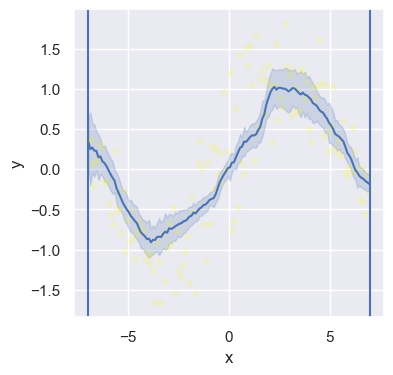

Epoch 149 | batch train loss: 0.0605924129486084 | test loss: 0.1949044002426995


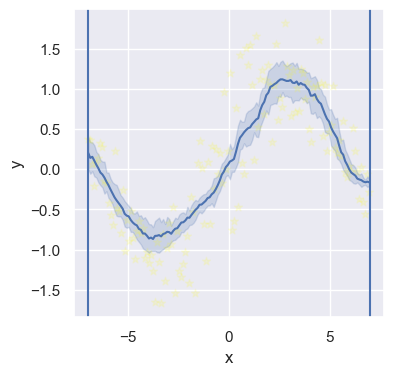

Epoch 149 | batch train loss: 0.09153149276971817 | test loss: 0.20835142665439182


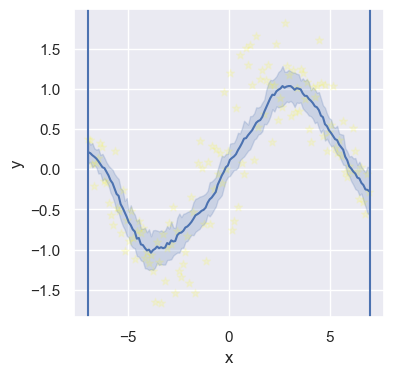

Epoch 149 | batch train loss: 0.03127020597457886 | test loss: 0.18971457911862266


In [20]:
train_losses_idd=[]
test_losses_idd=[]

for i in range(10):
  tr_loss,test_loss = MLE_mcdo_idd()
  train_losses_idd.append(tr_loss)
  test_losses_idd.append(test_loss)


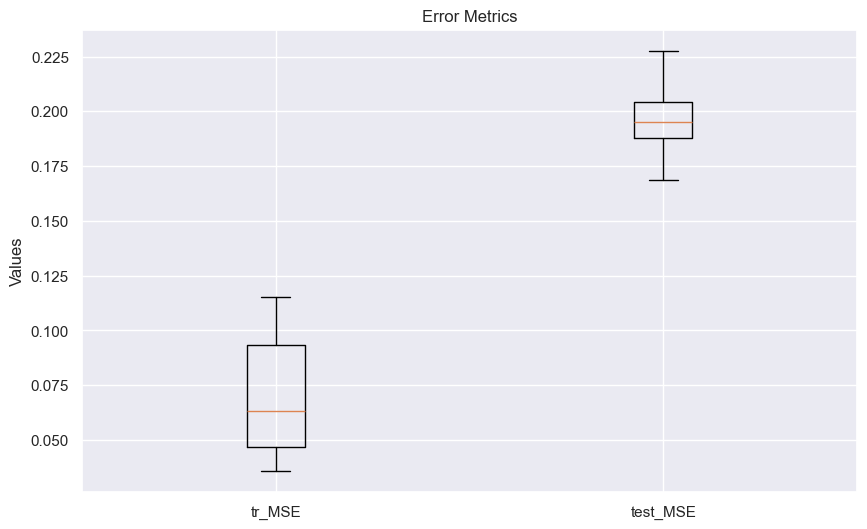

In [21]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [22]:

# mean_gaus_train_loss = np.mean(tr_loss_values)
# std_dev_gaus_train_loss = np.std(tr_loss_values)

# mean_gaus_test_loss = np.mean(test_loss_values)
# std_dev_gaus_test_loss = np.std(test_loss_values)

mean_mse_train = np.mean(tr_loss_values)
std_dev_mse_train = np.std(tr_loss_values)

mean_mse_test = np.mean(test_loss_values)
std_dev_mse_test = np.std(test_loss_values)

# print('Mean of Gausiann Training Loss of 10 runs ', mean_gaus_train_loss)
# print('Standard Deviation of Gausiann Training Loss of 10 runs ' , std_dev_gaus_train_loss )

# print('Mean of Gausiann Testing Loss of 10 runs ',mean_gaus_test_loss )
# print('Standard Deviation of Gausiann Testing Loss of 10 runs ',std_dev_gaus_test_loss)

print('Mean of MSE Training of 10 runs ',mean_mse_train)
print('Standard Deviation of MSE Training of 10 runs ' , std_dev_mse_train)

print('Mean of MSE Testing of 10 runs ',mean_mse_test )
print('Standard Deviation of MSE Testing of 10 runs ', std_dev_mse_test)

Mean of MSE Training of 10 runs  0.07005345188081265
Standard Deviation of MSE Training of 10 runs  0.026769862739347235
Mean of MSE Testing of 10 runs  0.1977954142368757
Standard Deviation of MSE Testing of 10 runs  0.017350810629663954


In [23]:
# Create a DataFrame from the lists
data = {
    'Training MSE': tr_loss_values,
    'Testing MSE': test_loss_values,

}

num_columns = len(data)

column_names = ['Training MSE','Testing MSE']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)
df.to_csv('results_mcdnn.csv', index=True)

    Training MSE  Testing MSE
1       0.103724     0.195600
2       0.043612     0.194609
3       0.056925     0.197828
4       0.081464     0.192689
5       0.097482     0.227667
6       0.068235     0.182596
7       0.035949     0.168452
8       0.057776     0.225813
9       0.039968     0.206247
10      0.115399     0.186454


In [24]:
print(test_loss_values)

[0.19559997205550855, 0.19460920129831022, 0.1978280280645077, 0.19268865768726057, 0.2276672239486988, 0.1825955561720408, 0.16845205196967492, 0.22581324439782363, 0.20624667062209204, 0.18645353615283966]
